# Clustering Crypto

In [14]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [2]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [3]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [75]:
# Alternatively, use the provided csv file:

from pathlib import Path
file_path = Path("crypto_data.csv")
df = pd.read_csv(file_path)
df.set_index('Unnamed: 0', inplace=True)
df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
Unnamed: 0,,,,,,
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [76]:
# Keep only necessary columns:

cols = ['CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply']
df = df[cols]
df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
Unnamed: 0,,,,,,
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [77]:
# Keep only cryptocurrencies that are trading
df_trading = df[df.IsTrading == True]
df_trading.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
Unnamed: 0,,,,,,
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [78]:
# Keep only cryptocurrencies with a working algorithm

sum(df_trading.Algorithm.isnull())
# All cryptos have a working algorithm

0

In [79]:
# Remove the "IsTrading" column

df_trading = df_trading.drop(columns = ['IsTrading'])

In [80]:
df_trading.head(3)

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
Unnamed: 0,,,,,
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
365,365Coin,X11,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000


In [81]:
# Remove rows with at least 1 null value
for column in df_trading.columns:
    print(f"Column {column} has {df_trading[column].isnull().sum()} null values")
print(f"Duplicate entries: {df_trading.duplicated().sum()}")

Column CoinName has 0 null values
Column Algorithm has 0 null values
Column ProofType has 0 null values
Column TotalCoinsMined has 459 null values
Column TotalCoinSupply has 0 null values
Duplicate entries: 0


In [82]:
df_trading.dropna(inplace=True)

In [83]:
for column in df_trading.columns:
    print(f"Column {column} has {df_trading[column].isnull().sum()} null values")
print(f"Duplicate entries: {df_trading.duplicated().sum()}")

Column CoinName has 0 null values
Column Algorithm has 0 null values
Column ProofType has 0 null values
Column TotalCoinsMined has 0 null values
Column TotalCoinSupply has 0 null values
Duplicate entries: 0


In [84]:
df_trading.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
Unnamed: 0,,,,,
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
808,808,SHA-256,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000


In [85]:
# Remove rows with cryptocurrencies having no coins mined

df_trading = df_trading[df_trading.TotalCoinsMined != 0]
df_trading.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
Unnamed: 0,,,,,
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,PoW,1.076842e+08,0


In [86]:
# Drop rows where there are 'N/A' text values
df_trading.isnull().sum()

CoinName           0
Algorithm          0
ProofType          0
TotalCoinsMined    0
TotalCoinSupply    0
dtype: int64

In [87]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df

coins_name = df_trading.CoinName.to_frame()
coins_name.head()

,CoinName
Unnamed: 0,
42,42 Coin
404,404Coin
1337,EliteCoin
BTC,Bitcoin
ETH,Ethereum


In [88]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm

df_trading.drop(columns=['CoinName'], inplace=True)
df_trading.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
Unnamed: 0,,,,
42,Scrypt,PoW/PoS,4.199995e+01,42
404,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,X13,PoW/PoS,2.927942e+10,314159265359
BTC,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethash,PoW,1.076842e+08,0


In [89]:
df_trading.dtypes

Algorithm           object
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply     object
dtype: object

In [90]:
# Create dummy variables for text features

X = pd.get_dummies(df_trading, columns=["Algorithm", "ProofType"])
X.shape
X.head(3)

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
42,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [91]:
# Standardize data

data_scaler = StandardScaler()
data_scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [92]:
X_scaled = data_scaler.transform(X)
X_scaled[1:]

array([[-0.09358885, -0.14499604, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [ 0.52587231,  4.4937636 , -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.11635442, -0.15255408, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       ...,
       [-0.09523411, -0.13215444, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.11658774, -0.15255408, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.11674507, -0.15284989, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ]])

### Reducing Dimensions Using PCA

In [93]:
# Use PCA to reduce dimensions to 3 principal components

pca = PCA(n_components=3)
coins_pca = pca.fit_transform(X_scaled)

In [96]:
# Create a DataFrame with the principal components data
pcs_df = pd.DataFrame(
    data=coins_pca, columns=["PC 1", "PC 2", "PC 3"], index=df_trading.index
)
pcs_df.head()

,PC 1,PC 2,PC 3
Unnamed: 0,,,
42,-0.332981,0.943650,-0.613667
404,-0.316304,0.943729,-0.614192
1337,2.313592,1.577694,-0.767406
BTC,-0.148416,-1.287989,0.169944
ETH,-0.152403,-1.998210,0.435083


In [97]:
pca.explained_variance_ratio_

array([0.02737243, 0.02090205, 0.02008775])

### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [98]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")


:Curve   [k]   (inertia)

Running K-Means with `k=4`

In [99]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(df_coin_pca)

# Predict clusters
predictions = model.predict(df_coin_pca)

In [105]:
# Create a new DataFrame named clustered_df, that includes the following columns 
# "Algorithm", "ProofType", "TotalCoinsMined", "TotalCoinSupply", "PC 1", "PC 2", "PC 3", "CoinName", "Class". 
# You should maintain the index of the crypto_df

# Create a new DataFrame including predicted clusters and cryptocurrencies features

clustered_data = {"Algorithm": df_trading.Algorithm,
               "ProofType": df_trading.ProofType, 
               "TotalCoinsMined": df_trading.TotalCoinsMined, 
               "TotalCoinSupply": df_trading.TotalCoinSupply,
               "PC 1": pcs_df["PC 1"], 
               "PC 2": pcs_df["PC 2"],
               "PC 3": pcs_df["PC 3"], 
               "CoinName": coins_name.CoinName,
               "Class": model.labels_
              }
clustered_df = pd.DataFrame(data = clustered_data, index=df_trading.index, )

clustered_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,CoinName,Class
Unnamed: 0,,,,,,,,,
42,Scrypt,PoW/PoS,4.199995e+01,42,-0.332981,0.943650,-0.613667,42 Coin,0
404,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.316304,0.943729,-0.614192,404Coin,0
1337,X13,PoW/PoS,2.927942e+10,314159265359,2.313592,1.577694,-0.767406,EliteCoin,0
BTC,SHA-256,PoW,1.792718e+07,21000000,-0.148416,-1.287989,0.169944,Bitcoin,1
ETH,Ethash,PoW,1.076842e+08,0,-0.152403,-1.998210,0.435083,Ethereum,1


### Visualizing Results

#### 3D-Scatter with Clusters

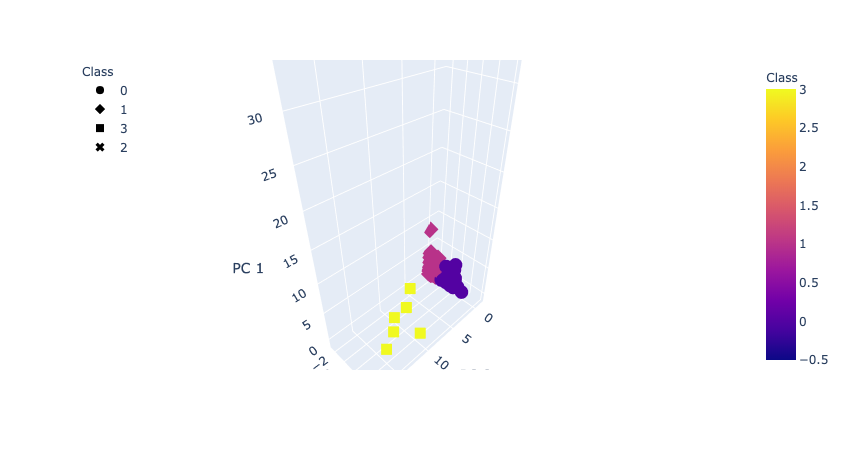

In [106]:
# Create a 3D-Scatter with the PCA data and the clusters

# Since we have three principal components, a 3D-Scatter plot is going to be created.
fig = px.scatter_3d(
    clustered_df,
    x="PC 3",
    y="PC 2",
    z="PC 1",
    color="Class",
    symbol="Class",
    width=500,
    hover_name="CoinName", 
    hover_data=["Algorithm"]
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [109]:
# Table with tradable cryptos

clustered_df.hvplot.table(columns=["CoinName", "Algorithm", "ProofType", "TotalCoinSupply", "TotalCoinsMined", "Class"], 
                          width=800)


:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,Class]

In [110]:
# Print the total number of tradable cryptocurrencies
print(f"Total number of tradable cryptocurrencies is {len(clustered_df)}.")

Total number of tradable cryptocurrencies is 533.


#### Scatter Plot with Tradable Cryptocurrencies

In [124]:
# Scale data to create the scatter plot
clustered_df_scaled = clustered_df
clustered_df_scaled["TotalCoinsMined"] = clustered_df_scaled["TotalCoinsMined"] / 1000000

In [129]:
clustered_df_scaled = clustered_df_scaled.astype({'TotalCoinSupply': 'float64'})
clustered_df_scaled.dtypes

Algorithm           object
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply    float64
PC 1               float64
PC 2               float64
PC 3               float64
CoinName            object
Class                int32
dtype: object

In [130]:
clustered_df_scaled["TotalCoinsMined"] = clustered_df_scaled["TotalCoinsMined"] / 1000000
clustered_df_scaled.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,CoinName,Class
Unnamed: 0,,,,,,,,,
42,Scrypt,PoW/PoS,4.199995e-11,4.200000e+01,-0.332981,0.943650,-0.613667,42 Coin,0
404,Scrypt,PoW/PoS,1.055185e-03,5.320000e+08,-0.316304,0.943729,-0.614192,404Coin,0
1337,X13,PoW/PoS,2.927942e-02,3.141593e+11,2.313592,1.577694,-0.767406,EliteCoin,0
BTC,SHA-256,PoW,1.792717e-05,2.100000e+07,-0.148416,-1.287989,0.169944,Bitcoin,1
ETH,Ethash,PoW,1.076842e-04,0.000000e+00,-0.152403,-1.998210,0.435083,Ethereum,1


In [132]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
clustered_df_scaled.hvplot.scatter(x = "TotalCoinsMined",
                            y = "TotalCoinSupply",
                            hover_cols=["CoinName"],
                            width=800,
                            height=500)

:Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)